<a href="https://colab.research.google.com/github/fellowship/-fitness-activity-recognition/blob/main/MoveNet_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
import time

model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [ ]:
# Configs
config = {
    "train_test_split":0.25,
    "random_state":4
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#import the annotated file here
annotated = pd.read_csv("/content/drive/MyDrive/for_running_code/annotated.csv")

In [ ]:
def videos_pose_estimation_coordinates(annotated_df, all_vids_path):
    """
    This function iterates through the names of a dictionary of annotated videos, finds the corresponding video in
    a given directory and creates movenet keypoints. All 2d points for all videos are saved to a csv file.
    :param annotated_df: Dataframe of all manually annotated videos
    :param all_vids_path: path containing all videos
    :return: N/A
    """
    data = pd.DataFrame()

    for i in range(0, annotated_df.shape[0]):
        if '.avi' in annotated_df['name'][i]:
            path = all_vids_path + '\\' + annotated_df['name'][i]
        else:
            path = all_vids_path + '\\' + annotated_df['name'][i] + '.mp4'

        vid_id = int(annotated_df['video_id'][i])
        length = int(annotated_df['Length'][i])
        actions = list(annotated_df.iloc[i][3: length + 3])

        cap = cv2.VideoCapture(path)

        if not cap.isOpened():
            print("Error opening video stream or file")

        fps = int(cap.get(cv2.CAP_PROP_FPS))

        vid_id_list = []
        points = []
        fps_list = []
        frame_list = []
        action_list = []
        max_frames = fps * length

        frame_count = 1
        seconds = 0
        while cap.isOpened():
            success, frame = cap.read()

            if not success or frame_count > max_frames:
                break

            # Resize image
            img = frame.copy()
            img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384, 640)
            input_img = tf.cast(img, dtype=tf.int32)

            # Detection section
            results = movenet(input_img)
            keypoints_with_scores = results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))

            points.append(keypoints_with_scores[0][:, :2].flatten())

            vid_id_list.append(vid_id)
            fps_list.append(fps)
            frame_list.append(frame_count)
            action_list.append(actions[seconds])

            if frame_count % fps == 0:
                seconds += 1

            frame_count += 1
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()

        sub = pd.DataFrame(points)
        sub.insert(0, 'fps', fps_list)
        sub.insert(0, 'frame_count', frame_list)
        sub.insert(0, 'video_id', vid_id_list)
        sub['actions'] = action_list

        data = data.append(sub, ignore_index=True)
        print(f"Annotated {i + 1} videos out of {annotated_df.shape[0]}")

    data.to_csv("new_csv_files/coordinates.csv", index=False)

In [ ]:
videos_pose_estimation_coordinates(annotated, "/content/drive/MyDrive/Fitness_videos")

Error opening video stream or file
Annotated 1 videos out of 1114
Error opening video stream or file
Annotated 2 videos out of 1114
Error opening video stream or file
Annotated 3 videos out of 1114
Error opening video stream or file
Annotated 4 videos out of 1114
Error opening video stream or file
Annotated 5 videos out of 1114
Error opening video stream or file
Annotated 6 videos out of 1114
Error opening video stream or file
Annotated 7 videos out of 1114
Error opening video stream or file
Annotated 8 videos out of 1114
Error opening video stream or file
Annotated 9 videos out of 1114
Error opening video stream or file
Annotated 10 videos out of 1114
Error opening video stream or file
Annotated 11 videos out of 1114
Error opening video stream or file
Annotated 12 videos out of 1114
Error opening video stream or file
Annotated 13 videos out of 1114
Error opening video stream or file
Annotated 14 videos out of 1114
Error opening video stream or file
Annotated 15 videos out of 1114
Erro

FileNotFoundError: ignored

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/for_running_code/coordinates.csv")

## Data Preprocessing

In [ ]:
#### NEW CLASSES HERE ####

# Excersices can be broadly categorized as: https://www.livestrong.com/article/534321-five-types-of-fitness-training/
## High intensity/speed
aerobic = ['jump_rope','jumping_jacks','dancing','jumping', 'x_jumps', 'running', 'all_fours_warm_up',
  'skii_hops','squat_jumps', 'lateral_squad_jumps','lateral_squat_jumps','lateral_shuffle','walking']

coordination_agility = ['agility_feet', 'run_in_place','standing_skips','high_knees', 
  'mountain_climbers','mountain_climber','boxing','high_knee_sprints','high_knee_sprint', 
  'burpy_crawl_combo','burpy', 'pace_skips', 'criss_cross','cross_crunches','surfer_hops',
  'split_hop','lower_knee_hop','torso_up_double_leg_extension'] # Could also fit in as a subclass of aerobic activities
# Could maybe also fit in with calisthenics?: 'burpy_crawl_combo','burpy'

## NOTE: Uncomment if combining coordination_agility with aerobic
# [aerobic.append(item) for item in coordination_agility]

## Medium intensity/speed and lifting 
# each below are subtypes of strength training (can use uniquely or put under strength training)
weight_bearing = ['bodyweight_squats','lateral_lunges','lunges','squats','body_weight_squats',
  'lateral_squat_walk_reverse_lundge','squat_hold_reverse_lundge','lateral_squat_walk_reverse_lundge',
  'body_weight_squat_toes','drop_squats']

# non_wieght_bearing = ['torso_up_double_leg_extension', 'hamstring_curl_right','hamstring_curl_left'] # (aka prone strength training)

calisthenics = ['knees_to_elbow', 'loaded_beast_push_up','modified_push_ups','crunches','pushups',
   'pullups','wall_pushups','pulse_ups_right','pulse_ups_left','straight_left_leg_pulse'] # (bodyweight excersizes)

weightlifting = ['bench_press','triceps','donkey_press','front_press','front_up_pulse']

## NOTE: Uncomment below if combining above classes into single strength training class
# comb_list =[weight_bearing, non_wieght_bearing, calisthenics, weightlifting]
# strength_training = [item for sublist in comb_list for item in sublist] # flat strength training list if single class preferred.

##### Lower intensity/speed (flexibility, stability) ######
balance_stability = ['bear_hold_knee_taps','bear_hold_shoulder_taps','bear_hold',
  'fullbody_walkouts', 'lay_down_knees_up', 'lay_down_one_knee_up','lay_down_knee_up_down',
  'lay_down_knee_swing_shoulder_blades_up','fire_hydrants','roll_up','alternating_deadbug',
  'single_bent_leg_lower','double_bent_leg_lower', 'double_leg_extension', 'upper_body_up_criss_cross',
  'bear_hold_taps','bear_crawl','forward_plank','left_side_plank','right_side_plank','arm_plank',
  'modified_arm_plank','left_side_plank_reaching','right_side_plank_reaching','kickbacks_right_glute',
  'straight_right_leg_pulse','kickbacks_left_glute','hip_bridge','forearm_plank','high_plank',
  'high_plank_right_leg_press','push_hip_up_right_leg','push_hip_up_left_leg','high_plank_shoulder_feet_combo',
  'straight_leg_lifts','push_hip_up_right_leg_up','hip_up_right_swing_down','push_hip_up_left_leg_up','hip_up_left_swing_down',
  'high_plank_left_leg_press','reverse_dog_crunch', 'all_fours_drive','forearm_plank_rocking','upper_body_up_double_leg_extension',
  'front_laying_leg_lifts','front_laying_arms_legs_lifts','plank_dynamic','plank_static','side_plank_dynamic','plank', 'hamstring_curl_right','hamstring_curl_left']
# Could fit in elsewhere also (calisthenics): alternating_deadbug, fire_hydrants, kickbacks_right_glute, 

flexibility = ['yoga,stretching','streching','yoga,','yoga,ground','yoga,all_four','yoga,standing'
  'strech','stretching', 'down_dog','up_dog','runners_lundge_reach','table_top','all_fours',
   'knees_to_chest','cat_cow','all_fours_elbow_spine_stretch','up_down_dog']
# Could be further split into dynamic and static stretches

idle = ['idle','all_fours_idle','standing','standing,talking','talking,walking','talking','standing_idle','standing_writing','walking_idle','kneeling_idle','table_top_position_idle','sitting','sitting_idle' 'laying_flat','laying_down_idle','laydown_faceup','laying_down_face_up','front_laying_position','laying_down_flat','laydown_face_up','laydown_flat','front_laying_idle', 'hanging']
doubt = ['transition','glutes','shuffle_position', 'adjusting','pointing']
remove = ['slides', 'off_screen', 'slide', 'pointing', 'offscreen','intro_page']

In [ ]:
def change_actions(x):
    if x in aerobic:
        return 'aerobic'
    elif x in coordination_agility:
        return 'coordination_agility'
    elif x in weight_bearing:
        return 'weight_bearing'
    elif x in calisthenics:
        return 'calisthenics'
    elif x in weightlifting:
        return 'weightlifting'
    elif x in balance_stability:
        return 'balance_stability'
    elif x in flexibility:
        return 'flexibility'
    elif x in remove:
        return 'remove'
    elif x in doubt:
        return "doubt"
    else:
        return 'idle'

In [ ]:
# Import Coordinates.csv here
data = pd.read_csv("drive/MyDrive/Fellowship.AI/coordinates.csv", index_col = 0)
data.head()

,video_id,frame_count,fps,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,actions
0,279,1,29,0.194167,0.474421,0.177525,0.486390,0.177479,0.467132,0.190676,...,0.514983,0.620077,0.467754,0.627111,0.503399,0.782260,0.464268,0.773160,0.460820,running
1,279,2,29,0.194559,0.473831,0.179554,0.483210,0.179706,0.468016,0.191008,...,0.516670,0.620963,0.461590,0.638270,0.504532,0.774690,0.468995,0.771903,0.470143,running
2,279,3,29,0.196080,0.468627,0.181912,0.478633,0.180850,0.463631,0.193267,...,0.508290,0.620228,0.462210,0.622819,0.478843,0.778599,0.492166,0.774354,0.489078,running
3,279,4,29,0.196092,0.468655,0.181905,0.478662,0.180863,0.463647,0.193274,...,0.508061,0.619862,0.462096,0.622813,0.479078,0.778002,0.492249,0.774339,0.489007,running
4,279,5,29,0.197715,0.467405,0.184015,0.475692,0.181017,0.464770,0.194321,...,0.515078,0.615721,0.476758,0.614663,0.496875,0.777589,0.512477,0.772853,0.513822,running


In [ ]:
def preprocess_data(annotated, data):
    req = annotated.iloc[:,3:].values.tolist()
    flatten = [items for lists in req for items in lists]
    flatten = [x for x in flatten if str(x) != 'nan']
    count_dict={}
    for action in flatten:
        if action in count_dict:
            count_dict[action]+=1
        else:
            count_dict[action]=1

    count = pd.DataFrame.from_dict(count_dict,orient = 'index')
    count.reset_index(inplace=True)
    count = count.rename(columns = {'index':'actions'})
    count['six_class']= count['actions'].apply(lambda x: change_actions(x))
    data['target']= data['actions'].apply(lambda x: change_actions(x))
    data.drop(['actions'] ,axis = 1,inplace = True)

In [ ]:
preprocess_data(annotated, data)

In [ ]:
# Moment (Our feature processing)
from scipy import stats
# Function to return the diffrence in coordinate of xth frame and x+nth frame
def data_transform(data, n, step, test =False):
    if test == False:
        segments = []
        labels = []
        video_id = []
        for id in data['video_id'].unique():
            sub_set = data[data["video_id"] == id]
            for i in range(0, sub_set.shape[0] - n, step):
                values = ((sub_set.iloc[i+n, 3:37] - sub_set.iloc[i, 3:37]) / sub_set.iloc[i+n, 3:37])
                label = stats.mode(sub_set['target'][i: i+n])[0][0]
                segments.append([values.append(sub_set.iloc[i+n, 3:37])])
                labels.append(label)
        
                

        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,68)
        df = pd.DataFrame(reshaped_segments)
        df['target'] = labels        
        return(df)
    else:
        segments = []
        data = pd.DataFrame(points)  
        for i in range(0, data.shape[0] - n, step):
            values = ((data.iloc[i+n, :] - data.iloc[i, :]) / data.iloc[i+n, :])
            segments.append([values.append(data.iloc[i+n, :])])
        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,68)
        return(reshaped_segments)
  

In [ ]:
data.groupby("target").size()

target
aerobic                  61328
balance_stability        94351
calisthenics             53790
coordination_agility     54150
doubt                      480
flexibility              70883
idle                    150154
remove                   18712
weight_bearing           41379
weightlifting            13825
dtype: int64

In [ ]:
# (5,5) - No -sampling - Moment
data_transformed = data_transform(data, 5,5)

remove_from_target = ['doubt', 'remove']

data_transformed = data_transformed[~data_transformed['target'].isin(remove_from_target)]

print(data_transformed.groupby("target").size())


X = data_transformed.iloc[:,:-1]
y =data_transformed['target']

target
aerobic                 12151
balance_stability       18821
calisthenics            10512
coordination_agility    10685
flexibility             14142
idle                    29925
weight_bearing           8170
weightlifting            2702
dtype: int64


In [ ]:
#from sklearn.preprocessing import LabelEncoder
# changing the target value to numeric value to fit the data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=config["train_test_split"], random_state=config["random_state"], shuffle  = True)

In [ ]:
# dave data_transformed to csv file
# data_transformed.to_csv("drive/MyDrive/Fellowship.AI/movenet_data_transformed.csv",sep='\t')

In [ ]:
# Helper function to calculate metrics and visualize data
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score,roc_auc_score, accuracy_score, log_loss
def metrics(model, X_train, y_train, X_test, y_test, cf_matrix = False):
    
    # Create a classifier
    

    # Use trained model to predict output of test dataset
    log_metric = 0
    predictions  = model.predict(X_test) 
    try:
      preds_probs = model.predict_proba(X_test)
      loss_metric =  log_loss(y_test, preds_probs)
    except:
      print("Model doesn't supports probability calculation")
    
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    f1 = f1_score(y_test, predictions, average='macro')
    precision = precision_score(y_test, predictions,average = 'micro', pos_label=1)
    recall = recall_score(y_test, predictions,average = 'micro', pos_label=1)
   
    print("ACCURACY PER INSTANCE:" ,accuracy)
    print("F1_score:" ,f1)
    print("Precision:", precision)
    print("Recall:",recall)
    if (loss_metric):
      print("Log Loss", loss_metric)
    (unique,count) = np.unique(le.inverse_transform(y_train),return_counts=True)
    class_labels = unique


    # plotting confusion matrix
    
    if cf_matrix == True:

        plt.figure(figsize = (16,6))
        sns.heatmap(pd.DataFrame(confusion_matrix(y_test , predictions)),annot=True, fmt="d",
                    xticklabels = class_labels, yticklabels = class_labels)

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        print(classification_report(y_test, predictions,target_names=class_labels))
        plt.show()

## XGBoost

In [ ]:
# XG Boost Classifier

from xgboost import XGBClassifier
xgb = XGBClassifier(objective=  'multi:softproba' , max_depth=15, random_state =config["random_state"] )
# Fit the classifier with the training data
xgb.fit(X_train,y_train)

XGBClassifier(max_depth=15, objective='multi:softprob', random_state=4)

ACCURACY PER INSTANCE: 0.907159129103335
F1_score: 0.8876867313971797
Precision: 0.907159129103335
Recall: 0.907159129103335
                      precision    recall  f1-score   support

             aerobic       0.86      0.84      0.85      3038
   balance_stability       0.91      0.96      0.93      4705
        calisthenics       0.90      0.88      0.89      2628
coordination_agility       0.89      0.84      0.86      2671
         flexibility       0.94      0.94      0.94      3535
                idle       0.91      0.93      0.92      7481
      weight_bearing       0.95      0.93      0.94      2043
       weightlifting       0.82      0.72      0.77       676

            accuracy                           0.91     26777
           macro avg       0.90      0.88      0.89     26777
        weighted avg       0.91      0.91      0.91     26777



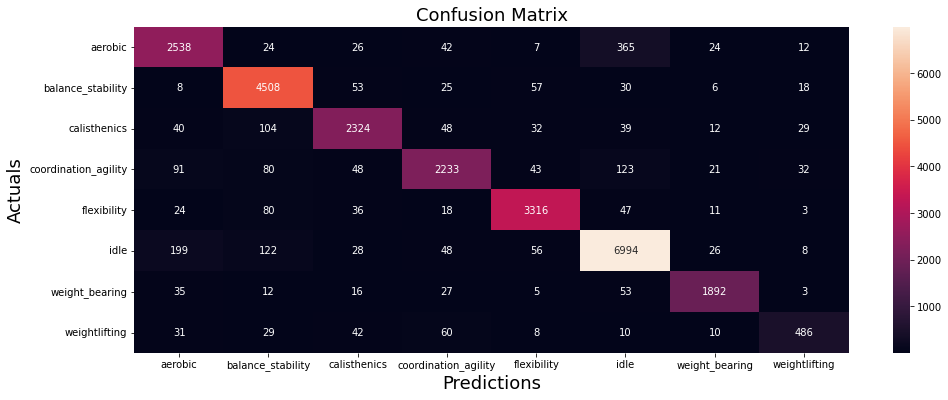

In [ ]:
metrics(xgb,X_train, y_train, X_test, y_test,cf_matrix=True)

## ExtraTrees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf_extra = ExtraTreesClassifier(n_estimators=500, random_state=config["random_state"])
clf_extra.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=500, random_state=4)

ACCURACY PER INSTANCE: 0.9222467042611197
F1_score: 0.9062255656524691
Precision: 0.9222467042611197
Recall: 0.9222467042611197
                      precision    recall  f1-score   support

             aerobic       0.89      0.87      0.88      3038
   balance_stability       0.92      0.97      0.94      4705
        calisthenics       0.93      0.90      0.91      2628
coordination_agility       0.91      0.86      0.88      2671
         flexibility       0.96      0.94      0.95      3535
                idle       0.92      0.95      0.93      7481
      weight_bearing       0.95      0.94      0.94      2043
       weightlifting       0.85      0.76      0.80       676

            accuracy                           0.92     26777
           macro avg       0.92      0.90      0.91     26777
        weighted avg       0.92      0.92      0.92     26777



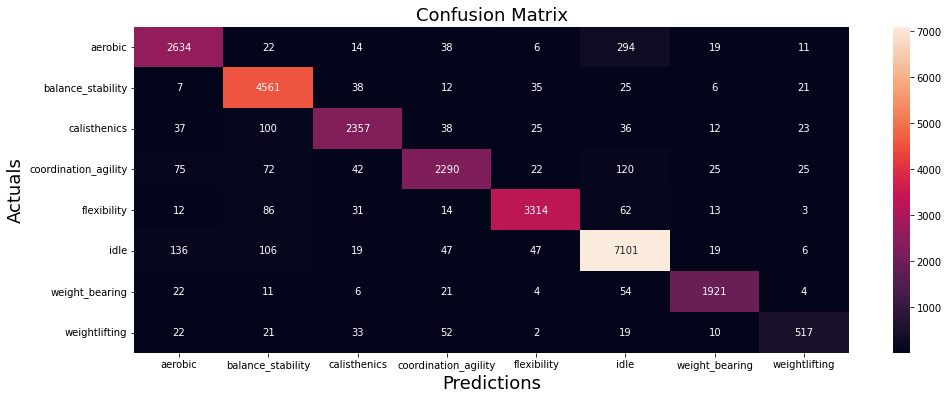

In [ ]:
metrics(clf_extra,X_train, y_train, X_test, y_test,cf_matrix=True)

## SVM

In [ ]:
# Scaling 
from sklearn.preprocessing import StandardScaler
sc1 = StandardScaler()
X_scaled = sc1.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= config["train_test_split"] )

In [ ]:
from sklearn.svm import SVC
clf_svm = SVC(decision_function_shape='ovo', probability=True, random_state=config["random_state"])
clf_svm.fit(X_train,y_train)

SVC(decision_function_shape='ovo', probability=True, random_state=4)

ACCURACY PER INSTANCE: 0.7100496694924748
F1_score: 0.6604654915003083
Precision: 0.7100496694924748
Recall: 0.7100496694924748
                      precision    recall  f1-score   support

             aerobic       0.64      0.41      0.50      3063
   balance_stability       0.69      0.87      0.77      4694
        calisthenics       0.77      0.61      0.68      2636
coordination_agility       0.75      0.54      0.63      2562
         flexibility       0.79      0.73      0.76      3610
                idle       0.68      0.88      0.76      7422
      weight_bearing       0.79      0.59      0.68      2094
       weightlifting       0.61      0.43      0.50       696

            accuracy                           0.71     26777
           macro avg       0.72      0.63      0.66     26777
        weighted avg       0.71      0.71      0.70     26777



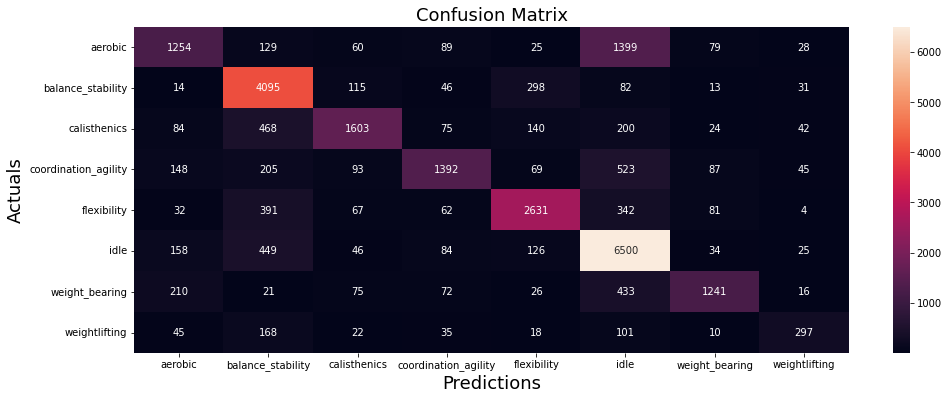

In [ ]:
metrics(clf_svm,X_train, y_train, X_test, y_test,cf_matrix=True)

## Multilayer Perceptrons / Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(hidden_layer_sizes=(128,10), batch_size=100, random_state=config["random_state"])
clf_nn.fit(X_train,y_train)

MLPClassifier(batch_size=100, hidden_layer_sizes=(128, 10), random_state=4)

ACCURACY PER INSTANCE: 0.8148037494864996
F1_score: 0.7856585516275303
Precision: 0.8148037494864996
Recall: 0.8148037494864996
                      precision    recall  f1-score   support

             aerobic       0.79      0.62      0.69      3063
   balance_stability       0.81      0.88      0.84      4694
        calisthenics       0.80      0.79      0.80      2636
coordination_agility       0.77      0.76      0.76      2562
         flexibility       0.86      0.87      0.86      3610
                idle       0.84      0.86      0.85      7422
      weight_bearing       0.80      0.89      0.84      2094
       weightlifting       0.67      0.60      0.63       696

            accuracy                           0.81     26777
           macro avg       0.79      0.78      0.79     26777
        weighted avg       0.81      0.81      0.81     26777



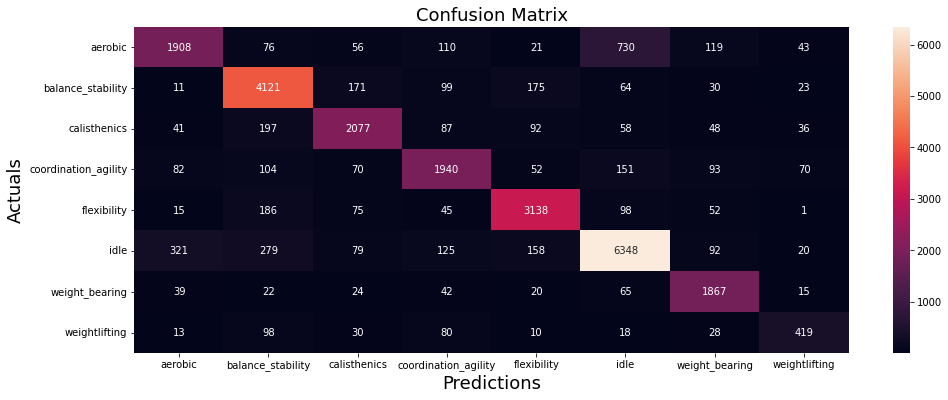

In [ ]:
metrics(clf_nn,X_train, y_train, X_test, y_test,cf_matrix=True)